Starte Skript: Stacking Ensemble (XGBoost + NN) Klassifikations-Pipeline

 TEIL 1 & 2: DATEN LADEN UND FEATURE ENGINEERING
1.1 Lade statische Attribute und filtere relevante Stationen...
--> 264 relevante Stationen für die Analyse gefunden.

1.2 Lade dynamische Zeitreihen für die ausgewählten Stationen...
--> Zeitreihen erfolgreich geladen.

1.3 Berechne monatliche Features aus jährlichen Werten...

1.4 Führe SGI-Berechnung und Feature-Engineering pro Station durch...


SGI-Berechnung & Dekomposition: 100%|██████████| 264/264 [00:50<00:00,  5.21it/s]



1.5 Führe dynamische und statische Features zusammen...

1.6 Erstelle zeitversetzte (Lag) Features und Zielvariable...

1.7 Wandle Zielvariable in Klassen um und kodiere kategorische Features...

1.7.1 Kodierung der kategorischen Features...
--> Folgende kategorische Spalten werden kodiert: ['main_landuse', 'month_num']
       - Kodiere 'main_landuse'...
       - Kodiere 'month_num'...

1.8 Bereinige finale Datensätze...

[SUCCESS] Teil 1 & 2 abgeschlossen.

 TEIL 3: MODELLTRAINING & EVALUATION (STACKING ENSEMBLE: XGBOOST + NN)
--> Erstelle zeitbasierten 80/10/10 Split für Stacking:
      - Training (Basis-Modelle): Jahre < 2008 (80%)
      - Validierung (Meta-Modell-Training): Jahre >= 2008 und < 2014 (10%)
      - Test (Finale Ensemble-Evaluation): Jahre >= 2014 (10%)

Größe der Datensätze:
      - Training (Basis):  129036 Zeilen
      - Validation (Meta): 19008 Zeilen
      - Test (Ensemble):   22176 Zeilen

-------------------------------------------------------------------------

[23:10:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


XGBoost Modell trainiert mit Parametern: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.8}

Trainiere Neuronales Netz Modell mit optimierten Parametern...


Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate

Neuronales Netz Modell trainiert mit Parametern: {'num_hidden_layers': 1, 'neurons_per_layer': (64,), 'learning_rate': 0.001, 'l2_reg': 0.001, 'dropout_rate': 0.3, 'batch_size': 256, 'epochs': 100, 'verbose': 0, 'callbacks': [<keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau object at 0x0000020630E24970>, <keras.src.callbacks.early_stopping.EarlyStopping object at 0x000002063FABE710>]}

--> Generiere Meta-Features für das Meta-Modell...
Meta-Features für Validierung erstellt. Shape: (19008, 8)
Meta-Features für Test erstellt. Shape: (22176, 8)

--> Starte Training des Meta-Modells (Logistic Regression)...
Meta-Modell Training abgeschlossen.

--------------------------------------------------------------------------------
 ENSEMBLE EVALUATION AUF TEST-DATEN
--------------------------------------------------------------------------------

Klassifikations-Metriken (Ensemble):
               precision    recall  f1-score   support

       Normal       0.86      0.92      0.89    

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

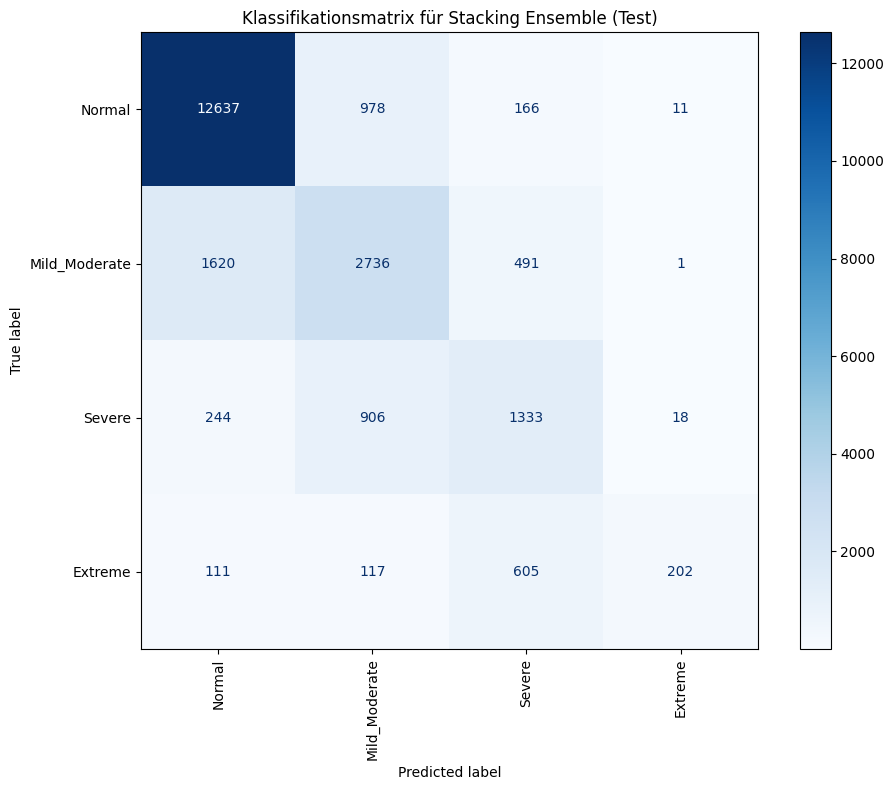


 TEIL 3C: MODELLINTERPRETATION DES ENSEMBLES

--> Berechne SHAP-Werte für das Meta-Modell (kann einen Moment dauern)...
DEBUG: SHAP-Werte-Typ (Meta-Modell): <class 'numpy.ndarray'>
DEBUG: SHAP-Werte-ist-Liste (Meta-Modell): False (Ist direkt ein Array o.ä.)
DEBUG: Shape des SHAP-Values-Arrays (Meta-Modell): (22176, 8, 4)

--> Erstelle SHAP Feature Importance Plot (global) für das Meta-Modell...
INFO: SHAP-Werte für Meta-Modell sind ein 3D NumPy-Array. Aggregiere für globalen Bar-Plot.


The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

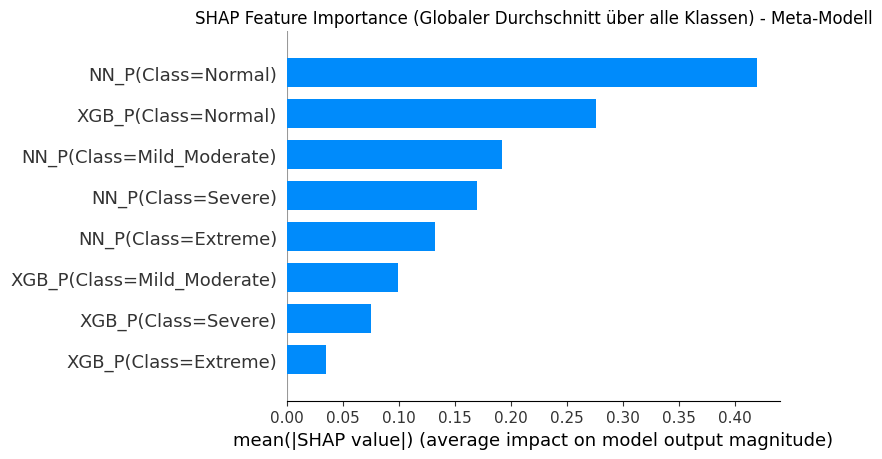


--> Erstelle SHAP Beeswarm Plots (Detailansicht) für jede Klasse des Meta-Modells...
       - Erstelle Beeswarm Plot für Klasse: 'Normal' (Index 0) - Meta-Modell


The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

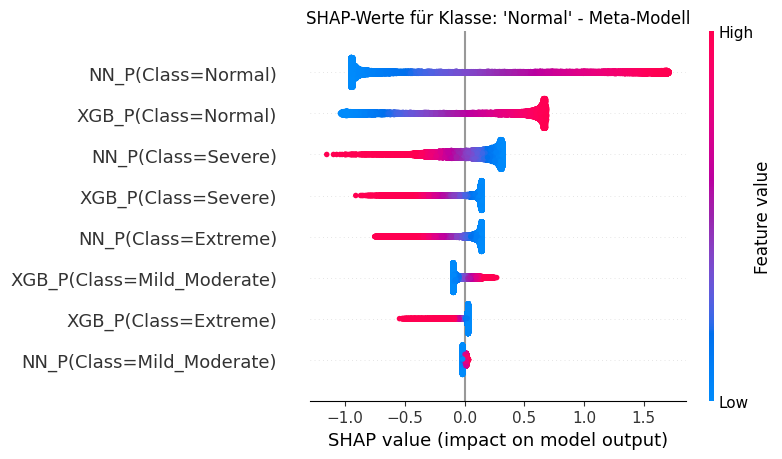

       - Erstelle Beeswarm Plot für Klasse: 'Mild_Moderate' (Index 1) - Meta-Modell


The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

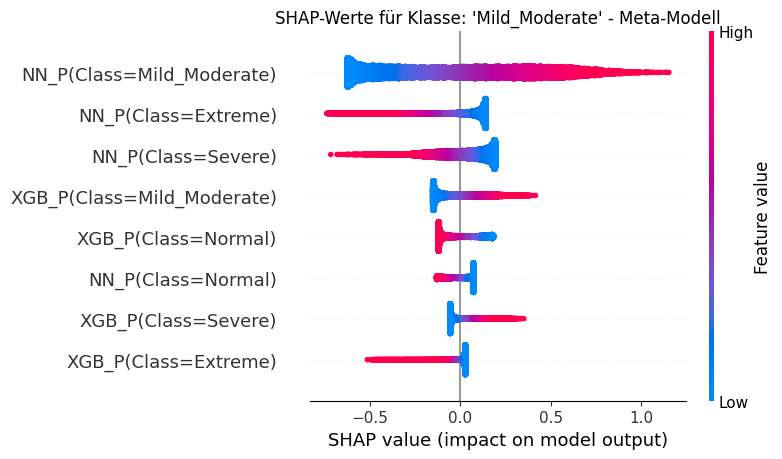

       - Erstelle Beeswarm Plot für Klasse: 'Severe' (Index 2) - Meta-Modell


The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

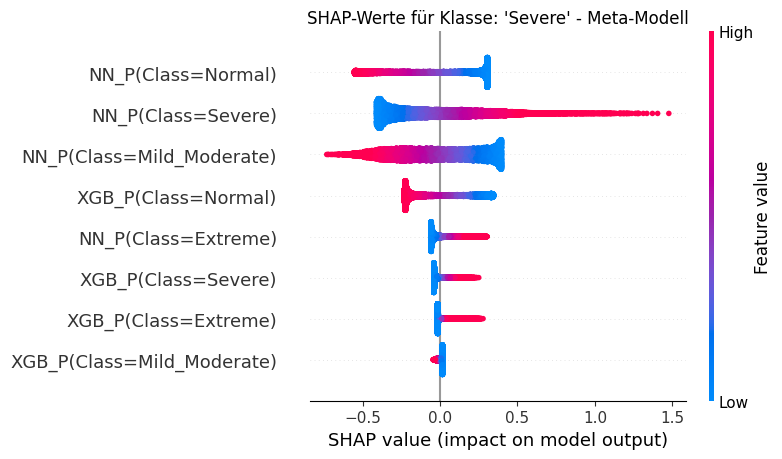

       - Erstelle Beeswarm Plot für Klasse: 'Extreme' (Index 3) - Meta-Modell


The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

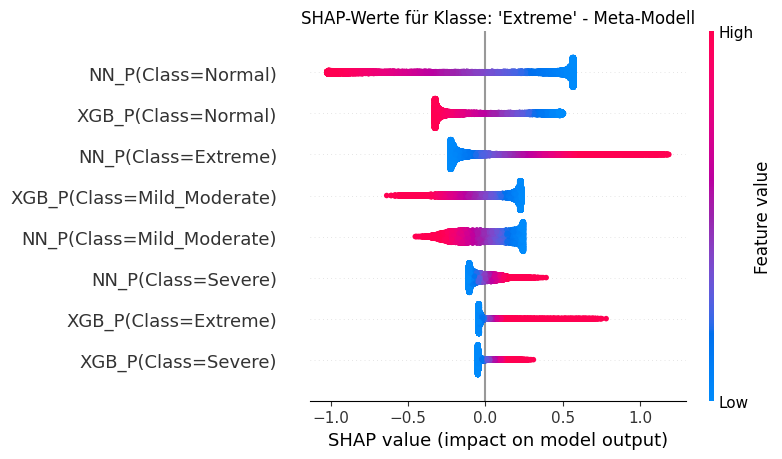


 TEIL 4: SPEICHERN DER ERGEBNISSE
--> Testdaten mit Ensemble-Vorhersagen und Wahrscheinlichkeiten gespeichert: test_data_final_stacking_ensemble_xgb_nn.csv

Skript vollständig abgeschlossen.


In [1]:
# --- TEIL 0: Bibliotheken importieren und Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import io

# Spezialisierte Bibliotheken
import pastas as ps                         # Für hydrologische Zeitreihenanalyse, speziell für SGI-Berechnung
import pyarrow.dataset as ds                # Zum effizienten Laden von Parquet-Dateien
import xgboost as xgb                       # XGBoost-Modell
import tensorflow as tf                     # Spezifisch für Neuronale Netze (Keras/TensorFlow)
import shap                                 # Für die Modell-Interpretation
from statsmodels.tsa.seasonal import STL    # Für die saisonale Zerlegung von Zeitreihen

# Wichtige Werkzeuge von Scikit-learn
from sklearn.model_selection import GridSearchCV, train_test_split # GridSearchCV und zusätzlicher Split
from sklearn.pipeline import Pipeline                               # Um mehrere Verarbeitungsschritte zu einem Modell zu verketten
from sklearn.preprocessing import StandardScaler                    # Zur Skalierung numerischer Features
from sklearn.impute import SimpleImputer                            # Zum Füllen von fehlenden Werten
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score # Zur Evaluation des Modells
from sklearn.linear_model import LogisticRegression                 # Meta-Modell
from sklearn.utils import class_weight # Für die Handhabung ungleicher Klassenverteilungen

# NEU: Import für KerasClassifier
from scikeras.wrappers import KerasClassifier

# Helfer-Bibliotheken
from tqdm import tqdm                       # Für schöne Fortschrittsbalken bei langen Schleifen
from contextlib import redirect_stdout      # Um störende Ausgaben von Bibliotheken zu unterdrücken
import io                                   # Für die Umleitung von Ausgaben

# --- Konfiguration ---
ps.set_log_level("ERROR")
print("Starte Skript: Stacking Ensemble (XGBoost + NN) Klassifikations-Pipeline")

# Setzen von Random Seeds für Reproduzierbarkeit
np.random.seed(42)
tf.random.set_seed(42)


# --- Definition der Features (UNVERÄNDERT) ---
STATIC_CATEGORICAL_FEATURES = ["main_landuse"]
STATIC_NUMERICAL_FEATURES = ["ground_elevation_m_asl", "topographic_slope_degrees"]
DYNAMIC_NUMERICAL_FEATURES_RAW = [
    "groundwater_level_m_asl", "precipitation_gpcc_mm_year-1",
    "potential_evapotranspiration_era5_mm_year-1", "air_temperature_°C", "snow_depth_m",
    "ndvi_ratio", "lai_low_vegetation_ratio", "lai_high_vegetation_ratio",
    "withdrawal_industrial_m3_year-1", "withdrawal_domestic_m3_year-1"
]

# --- TEIL 1 & 2: DATEN LADEN UND FEATURE ENGINEERING ---
print("\n" + "="*80); print(" TEIL 1 & 2: DATEN LADEN UND FEATURE ENGINEERING"); print("="*80)

# --- Schritt 1.1: Statische Attribute laden und filtern ---
print("1.1 Lade statische Attribute und filtere relevante Stationen...")
path_attributes = "C:/MLmitPython/ML-Python/Daten/grow_attributes.parquet"
path_timeseries = "C:/MLmitPython/ML-Python/Daten/grow_timeseries.parquet"
try:
    attr_df_full = pd.read_parquet(path_attributes)
except FileNotFoundError:
    raise

attr_filtered_df = attr_df_full[(attr_df_full["country"] == "CZE") & (attr_df_full["length_years"] >= 30) & (attr_df_full["gap_fraction"] == 0.0) & (pd.to_datetime(attr_df_full["ending_date"]) >= pd.Timestamp("2023-12-01"))]
if attr_filtered_df.empty:
    raise ValueError("Keine passende Zeitreihe für CZ für ML gefunden.")
cz_ids_for_ml = attr_filtered_df["GROW_ID"].dropna().unique().tolist()
print(f"--> {len(cz_ids_for_ml)} relevante Stationen für die Analyse gefunden.")

# --- Schritt 1.2: Dynamische Zeitreihen laden ---
print("\n1.2 Lade dynamische Zeitreihen für die ausgewählten Stationen...")
dynamic_feature_columns_to_load = ["GROW_ID", "date"] + DYNAMIC_NUMERICAL_FEATURES_RAW
try:
    timeseries_dataset_raw = ds.dataset(path_timeseries, format="parquet")
    available_columns_in_parquet = timeseries_dataset_raw.schema.names
    columns_to_actually_load = [col for col in dynamic_feature_columns_to_load if col in available_columns_in_parquet]
    timeseries_table_raw = timeseries_dataset_raw.to_table(filter=ds.field("GROW_ID").isin(cz_ids_for_ml), columns=columns_to_actually_load)
    raw_ts_df_full = timeseries_table_raw.to_pandas(self_destruct=True, split_blocks=True, zero_copy_only=False)
except FileNotFoundError:
    raise
raw_ts_df_full["date"] = pd.to_datetime(raw_ts_df_full["date"])
print("--> Zeitreihen erfolgreich geladen.")

# --- Schritt 1.3: Erste Feature-Anpassungen ---
print("\n1.3 Berechne monatliche Features aus jährlichen Werten...")
if "precipitation_gpcc_mm_year-1" in raw_ts_df_full.columns:
    raw_ts_df_full["precipitation_gpcc_mm_month-1"] = (raw_ts_df_full["precipitation_gpcc_mm_year-1"] / 12)
if "potential_evapotranspiration_era5_mm_year-1" in raw_ts_df_full.columns:
    raw_ts_df_full["potential_evapotranspiration_era5_mm_month-1"] = (raw_ts_df_full["potential_evapotranspiration_era5_mm_year-1"] / 12)

grouped_ts_data = raw_ts_df_full.set_index('date').groupby('GROW_ID')
del raw_ts_df_full; gc.collect()

# --- Schritt 1.4: Haupt-Feature-Engineering pro Station ---
print("\n1.4 Führe SGI-Berechnung und Feature-Engineering pro Station durch...")
def process_grow_id_data(grow_id_data):
    gwl_series_raw = grow_id_data["groundwater_level_m_asl"].dropna()
    if gwl_series_raw.empty or len(gwl_series_raw.resample('MS').mean().dropna()) < 120:
        return None
    gwl_series_monthly = gwl_series_raw.resample('MS').mean()

    try:
        with redirect_stdout(io.StringIO()):
            sgi_observed_monthly = ps.stats.sgi(gwl_series_monthly)
        if sgi_observed_monthly.empty or sgi_observed_monthly.isnull().all():
            return None
    except Exception:
        return None

    sgi_trend, sgi_seasonal, sgi_resid = (pd.Series(dtype=np.float32), pd.Series(dtype=np.float32), pd.Series(dtype=np.float32))
    sgi_for_stl = sgi_observed_monthly.dropna()
    if len(sgi_for_stl) >= 25:
        try:
            stl = STL(sgi_for_stl, period=12, robust=True); res_stl = stl.fit()
            sgi_trend, sgi_seasonal, sgi_resid = (res_stl.trend.reindex(sgi_observed_monthly.index), res_stl.seasonal.reindex(sgi_observed_monthly.index), res_stl.resid.reindex(sgi_observed_monthly.index))
        except Exception:
            pass

    monthly_features_dict = {'sgi_label': sgi_observed_monthly, 'sgi_trend': sgi_trend, 'sgi_seasonal': sgi_seasonal, 'sgi_resid': sgi_resid}
    dynamic_map = {"precipitation_gpcc_mm_month-1": "precipitation_monthly", "potential_evapotranspiration_era5_mm_year-1": "evapotranspiration_monthly", "air_temperature_°C": "air_temperature_monthly", "snow_depth_m": "snow_depth_monthly", "ndvi_ratio": "ndvi_monthly", "lai_low_vegetation_ratio": "lai_low_veg_monthly", "lai_high_vegetation_ratio": "lai_high_veg_monthly"}
    for orig, target in dynamic_map.items():
        monthly_features_dict[target] = grow_id_data[orig].dropna().resample('MS').mean().reindex(sgi_observed_monthly.index) if orig in grow_id_data.columns else pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)
    yearly_map = {"withdrawal_industrial_m3_year-1": "withdrawal_industrial_monthly", "withdrawal_domestic_m3_year-1": "withdrawal_domestic_monthly"}
    for orig, target in yearly_map.items():
        if orig in grow_id_data.columns:
            series_yearly = grow_id_data[orig].dropna(); series_yearly = series_yearly[~series_yearly.index.duplicated(keep='first')] if not series_yearly.index.is_unique else series_yearly; monthly_features_dict[target] = series_yearly.resample('MS').ffill().reindex(sgi_observed_monthly.index)
        else:
            monthly_features_dict[target] = pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)

    return pd.DataFrame(monthly_features_dict).dropna(subset=['sgi_label'])

processed_groups = []
for grow_id, group_data in tqdm(grouped_ts_data, desc="SGI-Berechnung & Dekomposition"):
    processed_df = process_grow_id_data(group_data)
    if processed_df is not None and not processed_df.empty:
        processed_df['GROW_ID'] = grow_id; processed_groups.append(processed_df)
if not processed_groups:
    raise ValueError("Keine Daten für ML-Modell nach Verarbeitung.")

# --- Schritt 1.5: Finale Datenzusammenführung und Feature-Erstellung ---
print("\n1.5 Führe dynamische und statische Features zusammen...")
df_ml_input_dynamic = pd.concat(processed_groups); del processed_groups; gc.collect()
static_features_to_select = ["GROW_ID"] + STATIC_NUMERICAL_FEATURES + STATIC_CATEGORICAL_FEATURES
static_features_to_select = [col for col in static_features_to_select if col in attr_df_full.columns]
attr_df_ml_static = attr_df_full[attr_df_full['GROW_ID'].isin(cz_ids_for_ml)][static_features_to_select].copy().drop_duplicates(subset=['GROW_ID'], keep='first')
df_ml_input_dynamic.reset_index(inplace=True)
df_ml_input = pd.merge(df_ml_input_dynamic, attr_df_ml_static, on="GROW_ID", how="left").set_index('date')
del df_ml_input_dynamic, attr_df_ml_static, attr_df_full, attr_filtered_df; gc.collect()
df_ml_processed = df_ml_input.copy(); del df_ml_input; gc.collect()

print("\n1.6 Erstelle zeitversetzte (Lag) Features und Zielvariable...")
for lag_col_base in ['sgi_label', 'sgi_trend', 'sgi_seasonal', 'sgi_resid']:
    if lag_col_base in df_ml_processed.columns:
        for lag_val in [1, 3, 6, 12]:
            df_ml_processed[f'{lag_col_base}_lag_{lag_val}M'] = df_ml_processed.groupby('GROW_ID')[lag_col_base].shift(lag_val)

df_ml_processed['month_num'] = df_ml_processed.index.month.astype(np.int8)
df_ml_processed['year'] = df_ml_processed.index.year.astype(np.int32)

VORHERSAGE_HORIZONT_MONATE = 6
sgi_target_col_continuous = f'sgi_target_{VORHERSAGE_HORIZONT_MONATE}M_future'
df_ml_processed[sgi_target_col_continuous] = df_ml_processed.groupby('GROW_ID')['sgi_label'].shift(-VORHERSAGE_HORIZONT_MONATE)

# --- Schritt 1.7: Zielvariable in Klassen umwandeln und Features vorbereiten ---
print("\n1.7 Wandle Zielvariable in Klassen um und kodiere kategorische Features...")
def sgi_to_drought_class(z_score):
    if pd.isna(z_score):
        return None
    if z_score > -0.84:
        return 'Normal'
    if -1.50 <= z_score <= -0.84:
        return 'Mild_Moderate'
    if -2.00 <= z_score <= -1.51:
        return 'Severe'
    return 'Extreme'
df_ml_processed['drought_class_str'] = df_ml_processed[sgi_target_col_continuous].apply(sgi_to_drought_class)
class_mapping = {'Normal': 0, 'Mild_Moderate': 1, 'Severe': 2, 'Extreme': 3}
df_ml_processed['drought_class_target'] = df_ml_processed['drought_class_str'].map(class_mapping).astype('Int64')
label_column_ml = 'drought_class_target'

print("\n1.7.1 Kodierung der kategorischen Features...")
categorical_cols_to_encode = [col for col in STATIC_CATEGORICAL_FEATURES if col in df_ml_processed.columns] + ['month_num']
print(f"--> Folgende kategorische Spalten werden kodiert: {categorical_cols_to_encode}")

dummy_encoded_cols_list = []
for col_to_encode in categorical_cols_to_encode:
    print(f"       - Kodiere '{col_to_encode}'...")
    dummies = pd.get_dummies(df_ml_processed[col_to_encode], prefix=col_to_encode, dummy_na=False, dtype=np.int8)
    df_ml_processed = pd.concat([df_ml_processed, dummies], axis=1); df_ml_processed.drop(columns=[col_to_encode], inplace=True)
    dummy_encoded_cols_list.extend(dummies.columns.tolist())

# --- Schritt 1.8: Finale Datenbereinigung ---
print("\n1.8 Bereinige finale Datensätze...")
numerical_static_cols_for_imputation = [col for col in STATIC_NUMERICAL_FEATURES if col in df_ml_processed.columns]
if numerical_static_cols_for_imputation:
    df_ml_processed[numerical_static_cols_for_imputation] = SimpleImputer(strategy='median').fit_transform(df_ml_processed[numerical_static_cols_for_imputation])

base_features_ml = ["precipitation_monthly", "evapotranspiration_monthly", "air_temperature_monthly", "snow_depth_monthly", "ndvi_monthly", "lai_low_veg_monthly", "lai_high_veg_monthly", "withdrawal_industrial_monthly", "withdrawal_domestic_monthly"]
lag_features_ml = [col for col in df_ml_processed.columns if '_lag_' in col]
current_sgi_features = ['sgi_label', 'sgi_trend', 'sgi_seasonal', 'sgi_resid']
features_columns_ml = list(set([col for col in base_features_ml if col in df_ml_processed.columns] + lag_features_ml + current_sgi_features + numerical_static_cols_for_imputation + dummy_encoded_cols_list))
columns_to_check_for_dropna_smart = [label_column_ml, 'sgi_label_lag_1M', 'precipitation_monthly']
df_ml_processed.dropna(subset=[col for col in columns_to_check_for_dropna_smart if col in df_ml_processed.columns], inplace=True)
df_ml_processed[label_column_ml] = df_ml_processed[label_column_ml].astype(int)

X_all_features_raw = df_ml_processed[features_columns_ml].copy()
y_all_labels = df_ml_processed[label_column_ml].copy()
X_meta_for_split = df_ml_processed[['GROW_ID', 'year']].copy()
del df_ml_processed; gc.collect()
print("\n[SUCCESS] Teil 1 & 2 abgeschlossen.")

# --- TEIL 3: MODELLTRAINING & EVALUATION (STACKING ENSEMBLE: XGBOOST + NN) ---
print("\n" + "="*80); print(" TEIL 3: MODELLTRAINING & EVALUATION (STACKING ENSEMBLE: XGBOOST + NN)"); print("="*80)

# --- Schritt 3.1: Zeitbasierter Train-Validation-Test Split ---
temp_year_series = X_meta_for_split['year']
unique_years_ml = np.sort(temp_year_series.unique())
split_year_1 = int(np.percentile(unique_years_ml, 80))
split_year_2 = int(np.percentile(unique_years_ml, 90))

train_mask = temp_year_series < split_year_1
val_mask = (temp_year_series >= split_year_1) & (temp_year_series < split_year_2)
test_mask = temp_year_series >= split_year_2

X_train_base, X_val_base, X_test_base = X_all_features_raw[train_mask], X_all_features_raw[val_mask], X_all_features_raw[test_mask]
y_train_base, y_val_base, y_test_base = y_all_labels[train_mask], y_all_labels[val_mask], y_all_labels[test_mask]

print(f"--> Erstelle zeitbasierten 80/10/10 Split für Stacking:")
print(f"      - Training (Basis-Modelle): Jahre < {split_year_1} (80%)")
print(f"      - Validierung (Meta-Modell-Training): Jahre >= {split_year_1} und < {split_year_2} (10%)")
print(f"      - Test (Finale Ensemble-Evaluation): Jahre >= {split_year_2} (10%)")

print(f"\nGröße der Datensätze:")
print(f"      - Training (Basis):  {X_train_base.shape[0]} Zeilen")
print(f"      - Validation (Meta): {X_val_base.shape[0]} Zeilen")
print(f"      - Test (Ensemble):   {X_test_base.shape[0]} Zeilen")
del X_all_features_raw, y_all_labels, X_meta_for_split; gc.collect()

# --- Schritt 3.2: Finale Feature-Übersicht ---
print("\n" + "-"*80)
features_in_model = sorted(X_train_base.columns.tolist())
print(f"--> Folgende {len(features_in_model)} Features werden für die Basis-Modelle verwendet:")
print("-" * 80)
max_len = max(len(f) for f in features_in_model) + 2
num_columns = 4
for i in range(0, len(features_in_model), num_columns):
    row = [f"{feat:<{max_len}}" for feat in features_in_model[i:i+num_columns]]
    print("".join(row))
print("-" * 80)

# --- Schritt 3.3: Training der Basis-Modelle (XGBoost und NN) ---
print("\n--> Starte Training der Basis-Modelle (XGBoost und NN) mit VORHER optimierten Parametern...")

# Bestimmte Parameter (aus separaten Tuning-Läufen)
best_params_xgb_found = {
    'n_estimators': 300,
    'learning_rate': 0.05,
    'max_depth': 7,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

best_params_nn_found = {
    'num_hidden_layers': 1,
    'neurons_per_layer': (64,),
    'learning_rate': 0.001,
    'l2_reg': 0.001,
    'dropout_rate': 0.3,
    'batch_size': 256,
    'epochs': 100,
    'verbose': 0,
    'callbacks': [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=0),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=0)
    ]
}

# --- XGBoost Modell trainieren ---
print("\nTrainiere XGBoost Modell mit optimierten Parametern...")
pipeline_xgb = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(class_mapping),
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1,
        **best_params_xgb_found
    ))
])
pipeline_xgb.fit(X_train_base, y_train_base)
best_xgb_model = pipeline_xgb
print(f"XGBoost Modell trainiert mit Parametern: {best_params_xgb_found}")


# --- Neuronales Netz Modell trainieren ---
print("\nTrainiere Neuronales Netz Modell mit optimierten Parametern...")

def create_nn_model_for_stacking(n_features, n_classes, num_hidden_layers, neurons_per_layer, dropout_rate, l2_reg, learning_rate):
    if isinstance(neurons_per_layer, int):
        neurons_per_layer = (neurons_per_layer,) * num_hidden_layers
    elif len(neurons_per_layer) != num_hidden_layers:
        raise ValueError("Anzahl der Neuronen in 'neurons_per_layer' muss der 'num_hidden_layers' entsprechen.")

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_features,)),
    ])
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(
            neurons_per_layer[i],
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
        ))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

class_weights_values_nn = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train_base), y=y_train_base
)
class_weights_dict_nn = dict(enumerate(class_weights_values_nn))

pipeline_nn = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', KerasClassifier(
        model=create_nn_model_for_stacking,
        n_features=X_train_base.shape[1],
        n_classes=len(class_mapping),
        num_hidden_layers=best_params_nn_found['num_hidden_layers'],
        neurons_per_layer=best_params_nn_found['neurons_per_layer'],
        dropout_rate=best_params_nn_found['dropout_rate'],
        l2_reg=best_params_nn_found['l2_reg'],
        learning_rate=best_params_nn_found['learning_rate'],
        batch_size=best_params_nn_found['batch_size'],
        epochs=best_params_nn_found['epochs'],
        verbose=best_params_nn_found['verbose'],
        callbacks=best_params_nn_found['callbacks'],
        random_state=42
    ))
])

pipeline_nn.fit(X_train_base, y_train_base, classifier__class_weight=class_weights_dict_nn)
best_nn_model = pipeline_nn
print(f"Neuronales Netz Modell trainiert mit Parametern: {best_params_nn_found}")


# --- Schritt 3.4: Meta-Features Generierung ---
print("\n--> Generiere Meta-Features für das Meta-Modell...")

xgb_val_proba = best_xgb_model.predict_proba(X_val_base)
nn_val_proba = best_nn_model.predict_proba(X_val_base)

class_names_list = list(class_mapping.keys())

meta_features_val = pd.DataFrame(
    np.hstack((xgb_val_proba, nn_val_proba)),
    index=X_val_base.index,
    columns=[f'XGB_P(Class={class_names_list[i]})' for i in range(len(class_mapping))] +
             [f'NN_P(Class={class_names_list[i]})' for i in range(len(class_mapping))]
)
y_meta_train = y_val_base

xgb_test_proba = best_xgb_model.predict_proba(X_test_base)
nn_test_proba = best_nn_model.predict_proba(X_test_base)

meta_features_test = pd.DataFrame(
    np.hstack((xgb_test_proba, nn_test_proba)),
    index=X_test_base.index,
    columns=[f'XGB_P(Class={class_names_list[i]})' for i in range(len(class_mapping))] +
             [f'NN_P(Class={class_names_list[i]})' for i in range(len(class_mapping))]
)
y_meta_test = y_test_base

print(f"Meta-Features für Validierung erstellt. Shape: {meta_features_val.shape}")
print(f"Meta-Features für Test erstellt. Shape: {meta_features_test.shape}")


# --- Schritt 3.5: Training des Meta-Modells ---
print("\n--> Starte Training des Meta-Modells (Logistic Regression)...")
meta_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=42, n_jobs=1, max_iter=200)
meta_model.fit(meta_features_val, y_meta_train)
print("Meta-Modell Training abgeschlossen.")

# --- Schritt 3.6: Ensemble-Evaluation ---
def evaluate_and_plot_ensemble(X_data_meta, y_data_true, dataset_name, ensemble_model, class_map):
    if X_data_meta.empty or y_data_true.empty:
        print(f"\n{dataset_name}-Datensatz für Ensemble ist leer. Evaluation wird übersprungen.")
        return None, None
    print("\n" + "-"*80); print(f" ENSEMBLE EVALUATION AUF {dataset_name.upper()}-DATEN"); print("-" * 80)

    y_pred_ensemble = ensemble_model.predict(X_data_meta)
    y_pred_proba_ensemble = ensemble_model.predict_proba(X_data_meta)

    class_names_ensemble = list(class_map.keys())
    print("\nKlassifikations-Metriken (Ensemble):")
    print(classification_report(y_data_true, y_pred_ensemble, labels=range(len(class_names_ensemble)), target_names=class_names_ensemble, zero_division=0))

    cm = confusion_matrix(y_data_true, y_pred_ensemble, labels=range(len(class_names_ensemble)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_ensemble)
    fig, ax = plt.subplots(figsize=(10, 8)); disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical'); ax.set_title(f'Klassifikationsmatrix für Stacking Ensemble ({dataset_name})'); plt.tight_layout(); plt.show()

    return y_pred_ensemble, y_pred_proba_ensemble

# Evaluierung des Ensembles auf den Testdaten
y_test_ensemble_pred, y_test_ensemble_pred_proba = evaluate_and_plot_ensemble(meta_features_test, y_meta_test, "Test", meta_model, class_mapping)


# --- TEIL 3C: MODELLINTERPRETATION DES ENSEMBLES (SHAP FÜR META-MODELL) ---
print("\n" + "="*80); print(" TEIL 3C: MODELLINTERPRETATION DES ENSEMBLES"); print("="*80)
try:
    if not meta_features_test.empty:
        print("\n--> Berechne SHAP-Werte für das Meta-Modell (kann einen Moment dauern)...")
        explainer_meta = shap.LinearExplainer(meta_model, meta_features_test)
        shap_values_meta = explainer_meta.shap_values(meta_features_test)

        print(f"DEBUG: SHAP-Werte-Typ (Meta-Modell): {type(shap_values_meta)}")
        if isinstance(shap_values_meta, list):
            print(f"DEBUG: SHAP-Werte-ist-Liste (Meta-Modell): True, Anzahl der Elemente: {len(shap_values_meta)}")
            if len(shap_values_meta) > 0:
                print(f"DEBUG: Typ des ersten SHAP-Array-Elements (Meta-Modell): {type(shap_values_meta[0])}")
                if hasattr(shap_values_meta[0], 'shape'):
                    print(f"DEBUG: Shape des ersten SHAP-Array-Elements (Meta-Modell): {shap_values_meta[0].shape}")
        else:
            print(f"DEBUG: SHAP-Werte-ist-Liste (Meta-Modell): False (Ist direkt ein Array o.ä.)")
            if hasattr(shap_values_meta, 'shape'):
                print(f"DEBUG: Shape des SHAP-Values-Arrays (Meta-Modell): {shap_values_meta.shape}")

        MAX_SHAP_FEATURES = 40

        print("\n--> Erstelle SHAP Feature Importance Plot (global) für das Meta-Modell...")
        if isinstance(shap_values_meta, np.ndarray) and shap_values_meta.ndim == 3:
            print("INFO: SHAP-Werte für Meta-Modell sind ein 3D NumPy-Array. Aggregiere für globalen Bar-Plot.")
            shap_values_for_global_plot = np.mean(np.abs(shap_values_meta), axis=2)

            shap.summary_plot(shap_values_for_global_plot, meta_features_test, plot_type="bar", max_display=MAX_SHAP_FEATURES, show=False)
            plt.title("SHAP Feature Importance (Globaler Durchschnitt über alle Klassen) - Meta-Modell")
            plt.tight_layout()
            plt.show()

            print("\n--> Erstelle SHAP Beeswarm Plots (Detailansicht) für jede Klasse des Meta-Modells...")
            for i, class_name in enumerate(list(class_mapping.keys())):
                print(f"       - Erstelle Beeswarm Plot für Klasse: '{class_name}' (Index {i}) - Meta-Modell")
                plt.figure(figsize=(12, 8))
                shap.summary_plot(shap_values_meta[:, :, i], meta_features_test, max_display=MAX_SHAP_FEATURES, feature_names=meta_features_test.columns, show=False)
                plt.title(f"SHAP-Werte für Klasse: '{class_name}' - Meta-Modell")
                plt.tight_layout()
                plt.show()

        elif isinstance(shap_values_meta, list) and len(shap_values_meta) > 1:
            print("INFO: SHAP-Werte für Meta-Modell sind Liste für Multiklasse. Aggregiere für globalen Bar-Plot.")
            shap_values_for_global_plot = np.mean(np.abs(np.array(shap_values_meta)), axis=0)

            shap.summary_plot(shap_values_for_global_plot, meta_features_test, plot_type="bar", max_display=MAX_SHAP_FEATURES, show=False)
            plt.title("SHAP Feature Importance (Globaler Durchschnitt über alle Klassen) - Meta-Modell")
            plt.tight_layout()
            plt.show()

            print("\n--> Erstelle SHAP Beeswarm Plots (Detailansicht) für jede Klasse des Meta-Modells...")
            if len(shap_values_meta) == len(class_mapping):
                for i, class_name in enumerate(list(class_mapping.keys())):
                    print(f"       - Erstelle Beeswarm Plot für Klasse: '{class_name}' (Index {i}) - Meta-Modell")
                    plt.figure(figsize=(12, 8))
                    shap.summary_plot(shap_values_meta[i], meta_features_test, max_display=MAX_SHAP_FEATURES, feature_names=meta_features_test.columns, show=False)
                    plt.title(f"SHAP-Werte für Klasse: '{class_name}' - Meta-Modell")
                    plt.tight_layout()
                    plt.show()
            else:
                print(f"WARNUNG: Anzahl der SHAP-Werte-Listen ({len(shap_values_meta)}) stimmt nicht mit der Anzahl der Klassen ({len(class_mapping)}) überein. Überspringe Beeswarm Plots pro Klasse für Meta-Modell.")

        else:
            print("INFO: SHAP-Werte für Meta-Modell sind kein Multiklassen-Format (oder nur eine Klasse). Erstelle einen einzelnen globalen Beeswarm/Bar-Plot.")
            shap.summary_plot(shap_values_meta, meta_features_test, max_display=MAX_SHAP_FEATURES, feature_names=meta_features_test.columns, show=False)
            plt.title("SHAP-Werte (Gesamt / Binäre Klassifikation) - Meta-Modell")
            plt.tight_layout()
            plt.show()
            print("WARNUNG: Keine Beeswarm Plots pro Klasse möglich, da SHAP-Werte nicht im Multiklassen-Listenformat vorliegen.")

    else:
        print("Testdaten für Meta-Modell sind leer, SHAP-Analyse wird übersprungen.")
except Exception as e:
    print(f"Fehler bei der SHAP-Analyse des Meta-Modells: {e}")
    import traceback
    traceback.print_exc()


# --- TEIL 4: SPEICHERN DER ERGEBNISSE ---
print("\n" + "="*80); print(" TEIL 4: SPEICHERN DER ERGEBNISSE"); print("=" * 80)
if not X_test_base.empty:
    test_results_ensemble_df = X_test_base.copy()
    test_results_ensemble_df[label_column_ml] = y_meta_test
    test_results_ensemble_df['ensemble_prediction'] = y_test_ensemble_pred
    proba_ensemble_df = pd.DataFrame(y_test_ensemble_pred_proba, columns=[f'ensemble_proba_{cls}' for cls in class_mapping.keys()], index=test_results_ensemble_df.index)
    test_results_ensemble_df = pd.concat([test_results_ensemble_df, proba_ensemble_df], axis=1)

    test_results_ensemble_df.to_csv("test_data_final_stacking_ensemble_xgb_nn.csv", index=True)
    print(f"--> Testdaten mit Ensemble-Vorhersagen und Wahrscheinlichkeiten gespeichert: test_data_final_stacking_ensemble_xgb_nn.csv")
else:
    print("--> Testdaten sind leer, keine Speicherung.")

print("\nSkript vollständig abgeschlossen.")